In [1]:
import sys
#sys.path.append('/home/leon/mishkin_affiliated/affnet/examples/hesaffnet')

In [2]:
sys.path.append('affnet')

In [3]:
from past import autotranslate

In [4]:
import matplotlib
#matplotlib.use('Agg')
import seaborn as sns
import os
import errno
import numpy as np
from PIL import Image
import sys
from copy import deepcopy
import argparse
import math
import torch.utils.data as data
import torch
import torch.nn.init
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as dset
import gc
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from tqdm import tqdm
import random
import cv2
import copy
from Utils import L2Norm, cv2_scale
#from Utils import np_reshape64 as np_reshape
np_reshape = lambda x: np.reshape(x, (64, 64, 1))
from Utils import str2bool
autotranslate(['dataset'])
from dataset import HPatchesDM,TripletPhotoTour, TotalDatasetsLoader
cv2_scale40 = lambda x: cv2.resize(x, dsize=(40, 40),
                                 interpolation=cv2.INTER_LINEAR)
from augmentation import get_random_norm_affine_LAFs,get_random_rotation_LAFs, get_random_shifts_LAFs
from LAF import denormalizeLAFs, LAFs2ell, abc2A, extract_patches,normalizeLAFs
from pytorch_sift import SIFTNet
from HardNet import HardNet, L2Norm, HardTFeatNet
from Losses import loss_HardNegC, loss_HardNet
from SparseImgRepresenter import ScaleSpaceAffinePatchExtractor
from LAF import denormalizeLAFs, LAFs2ell, abc2A,visualize_LAFs
from Losses import distance_matrix_vector
from ReprojectionStuff import get_GT_correspondence_indexes

import torch.nn.functional as F

In [5]:
#This is only siple example. It DOES NOT DO state-of-art image matching, not even close, because it is lacking RANSAC
import torch
import torch.nn as nn
import numpy as np
import sys
import os
import time

from PIL import Image
from torch.autograd import Variable
import torch.nn.functional as F
from SparseImgRepresenter import ScaleSpaceAffinePatchExtractor
from LAF import denormalizeLAFs, LAFs2ell, abc2A
from Utils import line_prepender
from architectures import AffNcetFast
from HardNet import HardNet

USE_CUDA = False

### Initialization
AffNetPix = AffNetFast(PS = 32)
weightd_fname = 'affnet/pretrained/AffNet.pth'

checkpoint = torch.load(weightd_fname)
AffNetPix.load_state_dict(checkpoint['state_dict'])

AffNetPix.eval()
    
detector = ScaleSpaceAffinePatchExtractor( mrSize = 5.192, num_features = 3000,
                                          border = 5, num_Baum_iters = 1, 
                                          AffNet = AffNetPix)
descriptor = HardNet()
model_weights = 'affnet/HardNet++.pth'
hncheckpoint = torch.load(model_weights)
descriptor.load_state_dict(hncheckpoint['state_dict'])
descriptor.eval()
if USE_CUDA:
    detector = detector.cuda()
    descriptor = descriptor.cuda()

affnet/architectures.py:242: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(m.weight.data, gain=0.8)
affnet/architectures.py:242: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(m.weight.data, gain=0.8)
affnet/architectures.py:242: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(m.weight.data, gain=0.8)
affnet/architectures.py:242: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(m.weight.data, gain=0.8)
affnet/architectures.py:242: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(m.weight.data, gain=0.8)
affnet/architectures.py:242: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(m.weight.data, gain=0.8)
affnet/architectures.py:242: UserWarning: nn.init.or

In [6]:
class OneSampleDatasetsLoader(data.Dataset):
    def __init__(self, datasets_path, train = True, transform = None, batch_size = None, n_triplets = 5000000, fliprot = False, *arg, **kw):
        super(OneSampleDatasetsLoader, self).__init__()
        datasets_path = [os.path.join(datasets_path, dataset) for dataset in os.listdir(datasets_path)]
        start = True
        for dataset_p in datasets_path:
            d = torch.load(dataset_p)
            if start:
                data = d[0]
                labels = d[1]
                start = False
            else:
                data = torch.cat([data, d[0]])
                labels = torch.cat([labels, d[1]+ torch.max(labels) + 1])
        #datasets = [torch.load(dataset) for dataset in datasets_path]
        #data, labels = datasets[0][0], datasets[0][1]
        #
        #for i in range(1,len(datasets)):
        #    data = torch.cat([data,datasets[i][0]])
        #    labels = torch.cat([labels, datasets[i][1]+torch.max(labels)+1])
        #
        #del datasets
        self.data, self.labels = data, labels
        self.transform = transform
        self.train = train
        self.n_triplets = n_triplets
        self.batch_size = batch_size
        self.fliprot = fliprot
        if self.train:
                print('Generating {} triplets'.format(self.n_triplets))
                self.pairs = self.generate(self.labels, self.n_triplets, self.batch_size)


    def generate(self, labels, num_triplets, batch_size):
            def create_indices(_labels):
                inds = dict()
                for idx, ind in enumerate(_labels):
                    if ind not in inds:
                        inds[ind] = []
                    inds[ind].append(idx)
                return inds
            triplets = []
            indices = create_indices(labels.numpy())
            unique_labels = np.unique(labels.numpy())
            n_classes = unique_labels.shape[0]
            # add only unique indices in batch
            already_idxs = set()
            for x in tqdm(range(num_triplets)):
                if len(already_idxs) >= batch_size:
                    already_idxs = set()
                c1 = unique_labels[np.random.randint(0, n_classes)]
                while c1 in already_idxs:
                    c1 = unique_labels[np.random.randint(0, n_classes)]
                already_idxs.add(c1)
                try:
                    y = indices[c1]
                except:
                    print(indices.keys())
                    sys.exit(0)
                if len(indices[c1]) == 2:  # hack to speed up process
                    n1, n2 = 0, 1
                else:
                    n1 = np.random.randint(0, len(indices[c1]))
#                     n2 = np.random.randint(0, len(indices[c1]))
#                     while n1 == n2:
#                         n2 = np.random.randint(0, len(indices[c1]))
                triplets.append(indices[c1][n1])
            return torch.LongTensor(np.array(triplets))

    def __getitem__(self, index):
            def transform_img(img):
                if self.transform is not None:
                    img = (img.numpy())/255.0
                    img = self.transform(img)
                return img

            t = self.pairs[index]
            a = self.data[t]
            img_a = transform_img(a)

            # transform images if required
            if self.fliprot:
                do_flip = random.random() > 0.5
                do_rot = random.random() > 0.5

                if do_rot:
                    img_a = img_a.permute(0,2,1)

                if do_flip:
                    img_a = torch.from_numpy(deepcopy(img_a.numpy()[:,:,::-1]))
            return img_a

    def __len__(self):
            if self.train:
                return self.pairs.size(0)


In [7]:
n_pairs = 1000000#0
b_size = 16

# def create_loaders():

#     kwargs = {'num_workers': 8, 'pin_memory': True}
#     transform = transforms.Compose([
#             transforms.Lambda(np_reshape),
#             transforms.ToTensor()
#             ])

#     train_loader = torch.utils.data.DataLoader(
#             TotalDatasetsLoader(
#                             datasets_path = 'affnet/dataset/6Brown', #datasets_path = args.dataroot,
#                             train=True,
#                              n_triplets = n_pairs, #n_triplets = 10000000,
#                              fliprot=True,
#                              batch_size=b_size,
#                              download=True,
#                              transform=transform),
#                              batch_size=b_size,
#                              shuffle=False, **kwargs)
#     return train_loader, None

def create_loaders():

    kwargs = {'num_workers': 8, 'pin_memory': True}
    transform = transforms.Compose([
            transforms.Lambda(np_reshape),
            transforms.ToTensor()
            ])

    train_loader = torch.utils.data.DataLoader(
            OneSampleDatasetsLoader(
                            datasets_path = 'affnet/dataset/6Brown', #datasets_path = args.dataroot,
                            train=True,
                             n_triplets = n_pairs, #n_triplets = 10000000,
                             fliprot=True,
                             batch_size=b_size,
                             download=True,
                             transform=transform),
                             batch_size=b_size,
                             shuffle=False, **kwargs)
    return train_loader, None

def extract_and_crop_patches_by_predicted_transform(patches, trans, crop_size = 32):
    assert patches.size(0) == trans.size(0)
    st = int((patches.size(2) - crop_size) / 2)
    fin = st + crop_size
    rot_LAFs = Variable(torch.FloatTensor([[0.5, 0, 0.5],[0, 0.5, 0.5]]).unsqueeze(0).repeat(patches.size(0),1,1));
    if patches.is_cuda:
        rot_LAFs = rot_LAFs.cuda()
        trans = trans.cuda()
    rot_LAFs1  = torch.cat([torch.bmm(trans, rot_LAFs[:,0:2,0:2]), rot_LAFs[:,0:2,2:]], dim = 2);
    return extract_patches(patches,  rot_LAFs1, PS = patches.size(2))[:,:, st:fin, st:fin].contiguous()
    
    
def extract_and_crop_patches_by_predicted_transform_featuremap(patches, trans, crop_size = 32):
    assert patches.size(0) == trans.size(0)
    st = int((patches.size(2) - crop_size) / 2)
    fin = st + crop_size
    rot_LAFs = Variable(torch.FloatTensor([[0.5, 0, 0.5],[0, 0.5, 0.5]]).unsqueeze(0).repeat(patches.size(0),1,1));
    if patches.is_cuda:
        rot_LAFs = rot_LAFs.cuda()
        trans = trans.cuda()
    rot_LAFs1  = torch.cat([torch.bmm(trans, rot_LAFs[:,0:2,0:2]), rot_LAFs[:,0:2,2:]], dim = 2);
    return extract_patches(patches,  rot_LAFs1, PS = patches.size(2))[:,:, st:fin, st:fin].contiguous()
    
    
    
def extract_random_LAF(data, max_rot = math.pi, max_tilt = 1.0, crop_size = 32):
    st = int((data.size(2) - crop_size)/2)
    fin = st + crop_size
    if type(max_rot) is float:
        rot_LAFs, inv_rotmat = get_random_rotation_LAFs(data, max_rot)
    else:
        rot_LAFs = max_rot
        inv_rotmat = None
    aff_LAFs, inv_TA = get_random_norm_affine_LAFs(data, max_tilt);
    aff_LAFs[:,0:2,0:2] = torch.bmm(rot_LAFs[:,0:2,0:2],aff_LAFs[:,0:2,0:2])
    data_aff = extract_patches(data,  aff_LAFs, PS = data.size(2))
    data_affcrop = data_aff[:,:, st:fin, st:fin].contiguous()
    return data_affcrop, data_aff, rot_LAFs,inv_rotmat,inv_TA

def load_grayscale_var(fname):
    img = Image.open(fname).convert('RGB')
    img = np.mean(np.array(img), axis = 2)
    var_image = torch.autograd.Variable(torch.from_numpy(img.astype(np.float32)), volatile = True)
    var_image_reshape = var_image.view(1, 1, var_image.size(0),var_image.size(1))
    if args.cuda:
        var_image_reshape = var_image_reshape.cuda()
    return var_image_reshape
def get_geometry_and_descriptors(img, det, desc, do_ori = True):
    with torch.no_grad():
        LAFs, resp = det(img,do_ori = do_ori)
        patches = det.extract_patches_from_pyr(LAFs, PS = 32)
        descriptors = desc(patches)
    return LAFs, descriptors


def adjust_learning_rate(optimizer, lr=0.0001):
    """Updates the learning rate given the learning rate decay.
    The routine has been implemented according to the original Lua SGD optimizer
    """
    for group in optimizer.param_groups:
        if 'step' not in group:
            group['step'] = 0.
        else:
            group['step'] += 1.
        group['lr'] = lr * (
        1.0 - float(group['step']) * float(b_size) / (n_pairs * float(20)))
    return

def create_optimizer(model, new_lr):
    optimizer = optim.SGD(model.parameters(), lr=new_lr,
                          momentum=0.9, dampening=0.9,
                          weight_decay=1e-4)
    return optimizer

In [8]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.orthogonal(m.weight.data, gain=0.6)
        try:
            nn.init.constant(m.bias.data, 0.01)
        except:
            pass
    return

class HardNetPart(nn.Module):
    """HardNetPart model definition
    """
    def __init__(self):
        super(HardNetPart, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias = False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(128, 128, kernel_size=8, bias = False),
            nn.BatchNorm2d(128, affine=False),
        )
        self.features.apply(weights_init)
        return
    
    def input_norm(self,x):
        flat = x.view(x.size(0), -1)
        mp = torch.mean(flat, dim=1)
        sp = torch.std(flat, dim=1) + 1e-7
        return (x - mp.detach().unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand_as(x)) / sp.detach().unsqueeze(-1).unsqueeze(-1).unsqueeze(1).expand_as(x)
    
    def forward(self, input):
        x_features = self.features(self.input_norm(input))
        x = x_features.view(x_features.size(0), -1)
        return L2Norm()(x)



In [9]:
train_loader, test_loader = create_loaders()

Generating 1000000 triplets


100%|██████████| 1000000/1000000 [00:03<00:00, 277922.55it/s]


In [10]:
from torch.nn import MSELoss

In [11]:
# PS = 32
# tilt_schedule = {'0': 3.0, '1': 4.0, '3': 4.5, '5': 4.8, '6': 5.2, '8':  5.8 }

# loss_f = MSELoss()
# LOG_DIR = './logs'
# def train(train_loader,test_loader, affnet, descriptor, hardnet_part, optimizer, epoch):
#     hardnet_part.train()
#     descriptor.eval()
#     dense_descriptor = nn.Sequential(*list(descriptor.features.children())[:-6])
#     pbar = tqdm(enumerate(train_loader))
#     for batch_idx, data in pbar:
# #         data_a, data_p = data
# #         data_a, data_p  = data_a.float().cuda(), data_p.float().cuda()
        
#         data_a, data_p = data
#         data_a = data_a.float().cuda()
        
        
#         st = int((data_p.size(2) - affnet.PS)/2)
        
        
#         #fin = st + model.PS
#         ep1 = epoch
#         while str(ep1) not in tilt_schedule.keys():
#             ep1 -=1
#             if ep1 < 0:
#                 break
#         max_tilt = tilt_schedule[str(ep1)]
        
#         data_a_aff_crop, data_a_aff, rot_LAFs_a, inv_rotmat_a, inv_TA_a = extract_random_LAF(data_a, math.pi, max_tilt, affnet.PS)
        
#         #data_p_aff_crop, data_p_aff, rot_LAFs_p, inv_rotmat_p, inv_TA_p = extract_random_LAF(data_p, rot_LAFs_a, max_tilt, affnet.PS)
        
# #         if inv_rotmat_p is None:
# #             inv_rotmat_p = inv_rotmat_a
        
        
#         #out_a_aff, out_p_aff = affnet(data_a_aff_crop,True), affnet(data_p_aff_crop,True)
        
#         out_a_aff = affnet(data_a_aff_crop,True)
#         #out_a_aff_back = torch.bmm(torch.bmm(out_a_aff, inv_TA_a),  inv_rotmat_a)
#         #out_p_aff_back = torch.bmm(torch.bmm(out_p_aff, inv_TA_p),  inv_rotmat_p)
#         ###### Get descriptors
        
#         out_patches_a_crop = extract_and_crop_patches_by_predicted_transform(data_a_aff, out_a_aff, crop_size = affnet.PS)
#         #out_patches_p_crop = extract_and_crop_patches_by_predicted_transform(data_p_aff, out_p_aff, crop_size = affnet.PS)
        
#         desc_features = dense_descriptor(data_a_aff_crop).detach()
        
#         basic_descriptor = descriptor(out_patches_a_crop).detach()
        
#         desc_a = descriptor(data_a_aff_crop)
        
#         desc_a = desc_a.detach()
#         #desc_p = descriptor(out_patches_p_crop)
        
        
#         #descr_dist =  torch.sqrt(((desc_a - desc_p)**2).view(data_a.size(0),-1).sum(dim=1) + 1e-6).mean()
        
#         #geom_dist = torch.sqrt(((out_a_aff_back - out_p_aff_back)**2 ).view(-1,4).sum(dim=1) + 1e-8).mean()
        
# #         if args.loss == 'HardNet':
# #             loss = loss_HardNet(desc_a,desc_p); 
# #         elif args.loss == 'HardNegC':
# #             loss = loss_HardNegC(desc_a,desc_p); 
# #         #elif args.loss == 'Geom':
# #         #    loss = geom_dist; 
# #         elif args.loss == 'PosDist':
# #             loss = descr_dist; 
# #         else:
# #             print('Unknown loss function')
# #             sys.exit(1)

#         print(out_a_aff.shape)
#         break
#         desc_features = extract_and_crop_patches_by_predicted_transform(desc_features, out_a_aff, crop_size = desc_features.shape[0])    
#         approxim = hardnet_part(desc_features)
        
#         loss = loss_f(approxim, desc_a)    
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         adjust_learning_rate(optimizer)
#         if batch_idx % 10 == 0:
#             pbar.set_description(
#                 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
#                     epoch, batch_idx * len(data_a), len(train_loader.dataset),
#                            100. * batch_idx / len(train_loader),
#                     float(loss.detach().cpu().numpy())))
#     torch.save({'epoch': epoch + 1, 'state_dict': hardnet_part.state_dict()},
#                '{}/checkpoint_{}.pth'.format(LOG_DIR,epoch))

In [12]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [13]:
%matplotlib inline
from LAF import visualize_LAFs
import seaborn as sns

In [14]:
import matplotlib.pyplot as plt

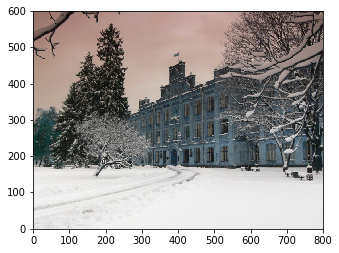

In [15]:
%matplotlib inline
import cv2
kpi_img = cv2.imread("/home/leon/mishkin_affiliated/affnet/examples/hesaffnet/img/kpi1.png")
kpi_img = np.flip(kpi_img,axis=0)
plt.imshow(kpi_img, origin='lower')
plt.show()

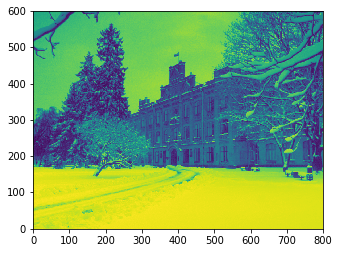

In [16]:
%matplotlib inline
plt.imshow(kpi_img[:,:,0],origin='lower')
plt.show()

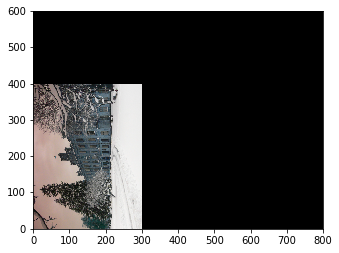

In [17]:
# def linear_transformation(src, a):
#     M, N = src.shape
#     points = np.mgrid[0:N, 0:M].reshape((2, M*N))
#     new_points = np.linalg.inv(a).dot(points).round().astype(int)
#     x, y = new_points.reshape((2, M, N), order='F')
#     indices = x + N*y
#     return np.take(src, indices, mode='wrap')


T1 = np.stack(np.array([[0,-1,int(kpi_img.shape[0]*0.5)],[1,0,0],[0,0,1]], dtype='float'))
T2 = np.stack(np.array([[0.5,0,0],[0,0.5,0],[0,0,1]], dtype='float'))
#T3 = np.stack(np.array([[0,0,89],[0,0,1],[0,0,1]], dtype='float'))
T = T1.dot(T2.T)[:2]

t_img = cv2.warpAffine(kpi_img,T,(kpi_img.shape[1],kpi_img.shape[0]))
plt.imshow(t_img,origin='lower')

plt.show()

In [18]:
T1 = np.stack(np.array([[0,-1, 0.5],[1,0,0.5],[0,0,1]], dtype='float'))
T2 = np.stack(np.array([[0.5,0,0],[0,0.5,0],[0,0,1]], dtype='float'))
T = T1.dot(T2)
# torch_matrix_scale_shift_to_affnet = torch.from_numpy(T1[:2]).cuda()
# torch_matrix_rotate_to_affnet = torch.from_numpy(T2[:2]).cuda()
torch_matrix_transforms_to_affnet = torch.from_numpy(T).float().t().unsqueeze(0).cuda()

In [19]:
#torch_matrix_scale_shift_from_affnet = torch.from_numpy(np.linalg.inv(T1)[:2]).cuda()
#torch_matrix_rotate_from_affnet = torch.from_numpy(np.linalg.inv(T2)[:2]).cuda()
#torch_matrix_transforms_from_affnet = torch.from_numpy(np.linalg.inv(T)).float().t().unsqueeze(0).cuda()
torch_matrix_transforms_from_affnet = torch.from_numpy(np.linalg.inv(T)).float().unsqueeze(0).cuda()

In [20]:
torch_matrix_transforms_from_affnet.shape

torch.Size([1, 3, 3])

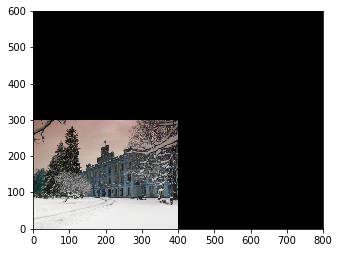

In [21]:
plt.imshow(cv2.warpAffine(kpi_img,T2[:2],(kpi_img.shape[1],kpi_img.shape[0])), origin='lower')

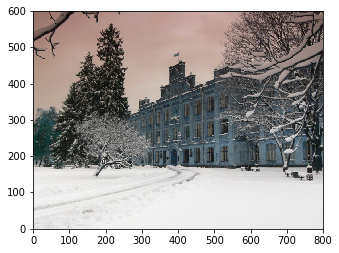

In [22]:
plt.imshow(kpi_img,origin='lower')


In [23]:
%matplotlib inline
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')
from LAF import denormalizeLAFs

PS = 32
tilt_schedule = {'0': 3.0, '1': 4.0, '3': 4.5, '5': 4.8, '6': 5.2, '8':  5.8 }

loss_f = MSELoss()
LOG_DIR = './logs'


def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__
    
    
def train(train_loader,test_loader, detector, descriptor, hardnet_part, optimizer, epoch):
    hardnet_part.train()
    descriptor.eval()
    
    dense_descriptor = nn.Sequential(*list(descriptor.features.children())[:-5])
    pbar = tqdm(enumerate(train_loader))
    for batch_idx, data_a in pbar:
#         data_a, data_p = data
#         data_a, data_p  = data_a.float().cuda(), data_p.float().cuda()
        
        #data_a, data_p = data
        data_a = data_a.float().cuda()
        
        
        st = int((data_a.size(2) - PS)/2)
        
        
        #fin = st + model.PS
        ep1 = epoch
        while str(ep1) not in tilt_schedule.keys():
            ep1 -=1
            if ep1 < 0:
                break
        max_tilt = tilt_schedule[str(ep1)]
        
        #data_a_aff_crop, data_a_aff, rot_LAFs_a, inv_rotmat_a, inv_TA_a = extract_random_LAF(data_a, math.pi, max_tilt, PS*2)
        
        #data_p_aff_crop, data_p_aff, rot_LAFs_p, inv_rotmat_p, inv_TA_p = extract_random_LAF(data_p, rot_LAFs_a, max_tilt, affnet.PS)
        
#         if inv_rotmat_p is None:
#             inv_rotmat_p = inv_rotmat_a
        
        
        #out_a_aff, out_p_aff = affnet(data_a_aff_crop,True), affnet(data_p_aff_crop,True)
        
        #out_a_aff = affnet(data_a_aff_crop,True)

        #print(data_a_aff_crop[0].unsqueeze_(0).shape)
        
        #print(get_geometry_and_descriptors(data_a_aff_crop[0].unsqueeze_(0), detector, descriptor))
        #geom_desc = [get_geometry_and_descriptors(d.unsqueeze_(0), detector, descriptor) for d in data_a_aff_crop]
        
        
        #out_a_aff, basic_descriptor = get_geometry_and_descriptors(data_a_aff_crop, detector, descriptor)
#         for d in data_a_aff_crop:
#             print(d.shape)
        #print(detector.AffNet(data_a).shape)
#        for image in data_a:
#             with HiddenPrints():
#                     LAFs, resp = detector(image.unsqueeze_(0), do_ori = True)
#                     patches = detector.extract_patches_from_pyr(LAFs, PS = PS)
            
            #out_a_aff = detector.AffNet(image)
#             print(LAFs.shape)
#             print(patches.squeeze().shape)
            
        patches, data_a_aff, rot_LAFs_a, inv_rotmat_a, inv_TA_a = extract_random_LAF(data_a, math.pi, max_tilt, PS)

        #print(data_a_aff.shape)
        transforms = detector.AffNet(data_a_aff)
        transformed_patches =  extract_and_crop_patches_by_predicted_transform_featuremap(data_a_aff, transforms, crop_size = PS)  
#         print(transformed_patches.detach().cpu()[0].shape)
#         fig, ax = plt.subplots(2)
#         ax[0].imshow(transformed_patches.detach().cpu()[0][0])
#         ax[1].imshow(data_a.detach().cpu()[0][0])
#         plt.show()
#         break
        desc_features = dense_descriptor(patches).detach()

        desc_a = descriptor(patches)

        desc_a = desc_a.detach()
        #print(transformed_patches[0].cpu().detach().numpy()[0].shape)
        
        
 
        
#         grid_original_image  = F.affine_grid(out_a_aff, patches.size())
#         transformed_patches = F.grid_sample(patches, grid_original_image)
        transformed_descriptors = descriptor(transformed_patches).detach()

#             grid  = F.affine_grid(out_a_aff, desc_features.size())
#             desc_features = F.grid_sample(desc_features, grid)
       
#         print('transforms',transforms.shape)
#         print('data_a_aff',data_a_aff.shape)
#         print('patches',patches.shape)
#         print('transformed_patches',transformed_patches.shape)
#         print('desc_features',desc_features.shape)
        
    
    
#        transforms_padding = Variable(torch.zeros(transforms.shape[0],transforms.shape[1],1)).cuda()
#        transforms = torch.cat((transforms,transforms_padding),2)
        
        #converting transform matrixes from 2x2 to 3x3 format
        
        #fig = plt.figure(figsize=(8,8))
        
        
        #fig.add_subplot(1,1,1)
        plt.imshow(data_a[0].cpu().detach().numpy()[0])
        plt.show()
        
        plt.imshow(transformed_patches[0].cpu().detach().numpy()[0])
        plt.show()
        
        
        if(batch_idx>10):
            break
        
        transforms_padding = Variable(torch.zeros(transforms.shape[0],transforms.shape[1],1)).cuda()
        transforms = torch.cat((transforms,transforms_padding),2)
      
        
        transforms_padding = Variable(torch.zeros(transforms.shape[0],1,3)).cuda()
        transforms = torch.cat((transforms,transforms_padding),1)
        transforms[:,2,2] = 1
        
        
        
        #transforms = transforms.dot(torch_matrix_rotate_to_affnet.t())#[:,:2,:2]
        #print(transforms.shape)
        #print(torch_matrix_transforms_to_affnet.expand(transforms.shape).shape)
        transforms = torch.bmm(transforms,torch_matrix_transforms_to_affnet.expand(transforms.shape))#[:,:2,:2]
        #print(transforms.transpose(1,2).shape)
        transforms = torch.bmm(torch_matrix_transforms_from_affnet.expand(transforms.shape),transforms.transpose(1,2))
        #print(transforms.shape)
        transforms = transforms[:,:2,:]
        
#         test_transforms = torch.bmm(torch_matrix_transforms_from_affnet,torch_matrix_transforms_to_affnet.expand(transforms.shape))
#         test_transforms = test_transforms[:,:2,:]
        grid_test  = F.affine_grid(transforms, data_a_aff.size())
        transformed_patches_test = F.grid_sample(data_a_aff, grid_test)
        print(transformed_patches_test.shape)
        print(int(transformed_patches_test.shape[2]))
        transformed_patches_test = transformed_patches_test[:,:,int(transformed_patches_test.shape[2]*0.25):int(transformed_patches_test.shape[2]*0.75),int(transformed_patches_test.shape[3]*0.25):int(transformed_patches_test.shape[3]*0.75)]
        print(transformed_patches_test.shape)
        plt.imshow(transformed_patches_test[0].cpu().detach().numpy()[0])
        
        plt.show()
        
        grid  = F.affine_grid(transforms, desc_features.size())
        desc_features = F.grid_sample(desc_features, grid)
        #print('desc_features',desc_features.shape)
        
#         print(hardnet_part(desc_features).shape)
        #print(desc_a.shape)
        approxim = hardnet_part(desc_features)+desc_a

        loss = loss_f(approxim, transformed_descriptors)    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        adjust_learning_rate(optimizer)
        if batch_idx % 10 == 0:
            pbar.set_description(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                    epoch, batch_idx * len(data_a), len(train_loader.dataset),
                           100. * batch_idx / len(train_loader),
                    float(loss.detach().cpu().numpy())))
    torch.save({'epoch': epoch + 1, 'state_dict': hardnet_part.state_dict()},
               '{}/checkpoint_{}.pth'.format(LOG_DIR,epoch))

0it [00:00, ?it/s]

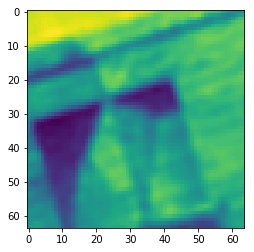

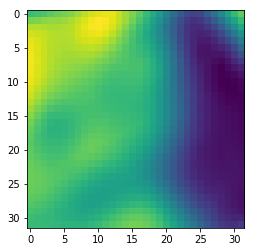

torch.Size([16, 1, 64, 64])
64
torch.Size([16, 1, 32, 32])


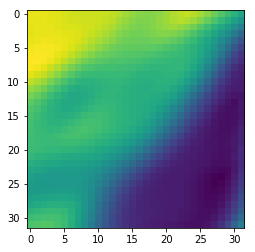

Train Epoch: 0 [0/1000000 (0%)]	Loss: 0.0123: : 1it [00:00,  3.24it/s]

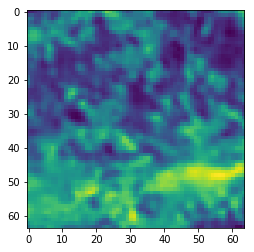

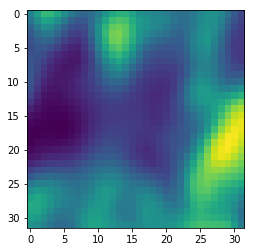

torch.Size([16, 1, 64, 64])
64
torch.Size([16, 1, 32, 32])


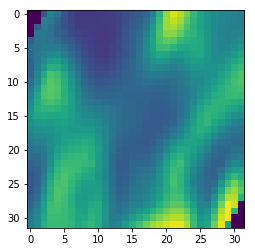

Train Epoch: 0 [0/1000000 (0%)]	Loss: 0.0123: : 2it [00:00,  3.67it/s]

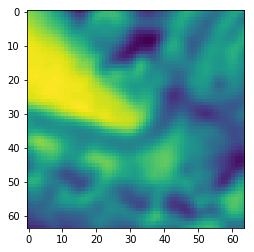

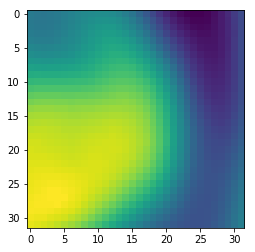

torch.Size([16, 1, 64, 64])
64
torch.Size([16, 1, 32, 32])


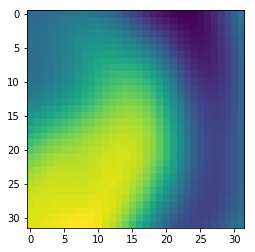

Train Epoch: 0 [0/1000000 (0%)]	Loss: 0.0123: : 3it [00:00,  3.83it/s]

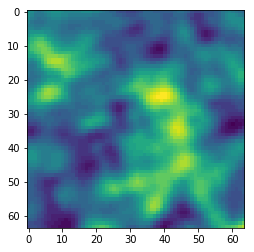

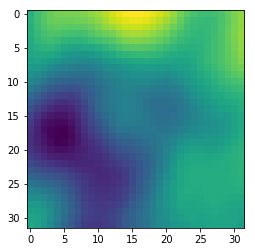

torch.Size([16, 1, 64, 64])
64
torch.Size([16, 1, 32, 32])


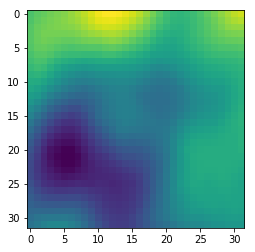

Train Epoch: 0 [0/1000000 (0%)]	Loss: 0.0123: : 4it [00:01,  3.92it/s]

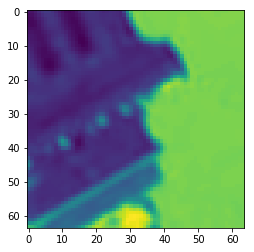

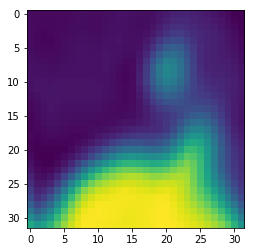

torch.Size([16, 1, 64, 64])
64
torch.Size([16, 1, 32, 32])


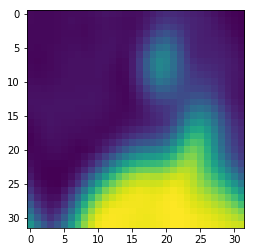

Train Epoch: 0 [0/1000000 (0%)]	Loss: 0.0123: : 5it [00:01,  3.97it/s]

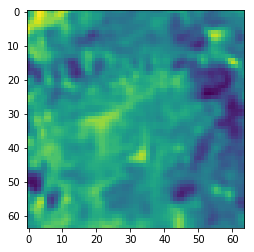

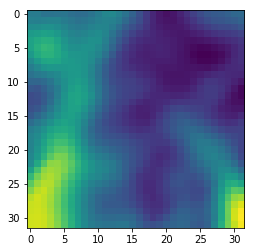

torch.Size([16, 1, 64, 64])
64
torch.Size([16, 1, 32, 32])


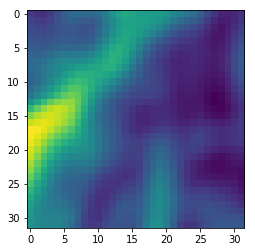

Train Epoch: 0 [0/1000000 (0%)]	Loss: 0.0123: : 6it [00:01,  4.00it/s]

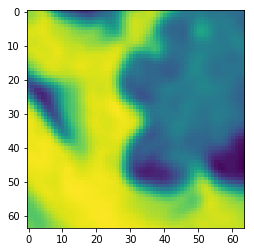

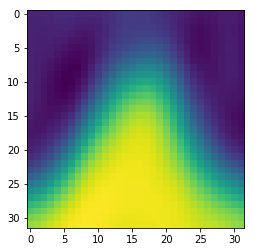

torch.Size([16, 1, 64, 64])
64
torch.Size([16, 1, 32, 32])


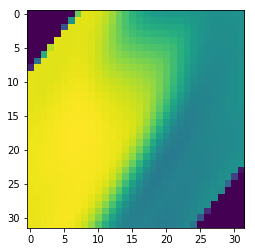

Train Epoch: 0 [0/1000000 (0%)]	Loss: 0.0123: : 7it [00:01,  4.03it/s]

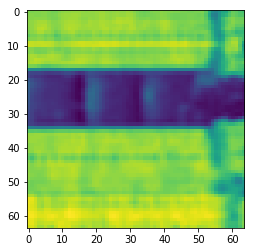

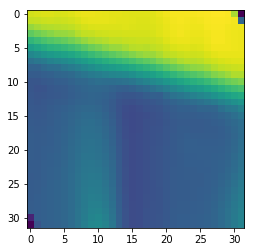

torch.Size([16, 1, 64, 64])
64
torch.Size([16, 1, 32, 32])


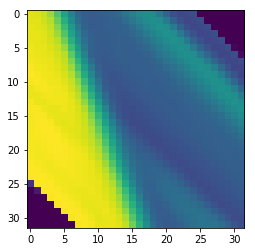

Train Epoch: 0 [0/1000000 (0%)]	Loss: 0.0123: : 8it [00:01,  4.04it/s]

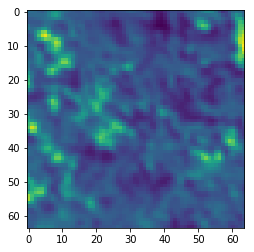

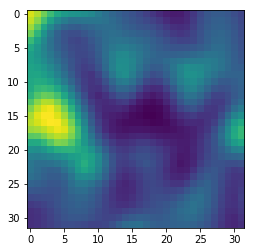

torch.Size([16, 1, 64, 64])
64
torch.Size([16, 1, 32, 32])


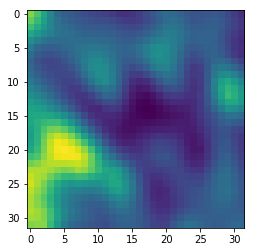

Train Epoch: 0 [0/1000000 (0%)]	Loss: 0.0123: : 9it [00:02,  4.05it/s]

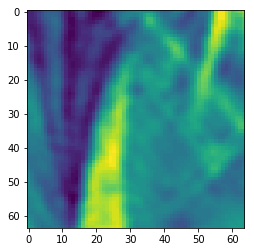

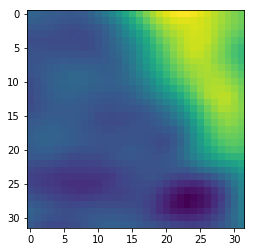

torch.Size([16, 1, 64, 64])
64
torch.Size([16, 1, 32, 32])


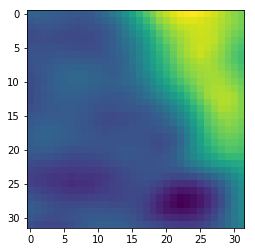

Train Epoch: 0 [0/1000000 (0%)]	Loss: 0.0123: : 10it [00:02,  4.05it/s]

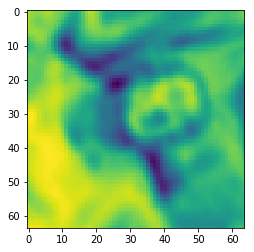

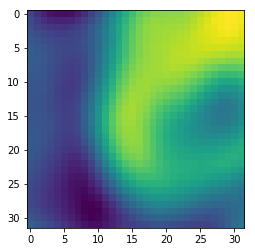

torch.Size([16, 1, 64, 64])
64
torch.Size([16, 1, 32, 32])


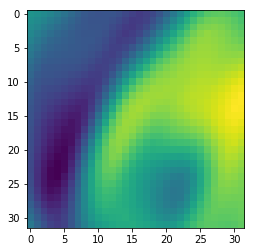

Train Epoch: 0 [160/1000000 (0%)]	Loss: 0.0145: : 11it [00:02,  4.05it/s]

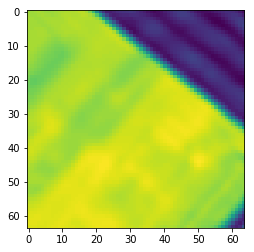

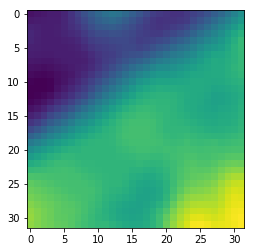

In [24]:
hdnt_part = HardNetPart()
hdnt_part.cuda()
AffNetPix.cuda()
descriptor.cuda()
detector.cuda()
#optimizer1 = torch.optim.Adam(hdnt_part.parameters(), lr = 0.0001)
optimizer1 = create_optimizer(hdnt_part, 0.0001)
epoch = 1
for e in range(epoch):
    train(train_loader,test_loader, detector, descriptor, hdnt_part, optimizer1, e)

In [25]:
detector.AffNet

AffNetFast(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (14): 

grid_original_image  = F.affine_grid(out_a_aff, patches.size())<br>
transformed_patches = F.grid_sample(patches, grid_original_image))<br>
transformed_descriptors = descriptor(transformed_patches).detach())<br>
            
out_a_aff выдает чуть не тот формат, что нравится F.affine_grid
чтобы использовать out_a_aff, нужно использовать extract_patches
как в трейне аффнета тут
https://github.com/ducha-aiki/affnet/blob/master/train_AffNet_test_on_graffity.py#L217
Понял

вообще перед тренировкой и вообще использованием spatial transformers советую поиграться просто с картинкой - чтобы оно на вид правильно все экстрактило